<a href="https://colab.research.google.com/github/cehkop/Deep_learning_school_MIPT/blob/main/homework/semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>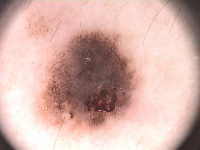</td><td>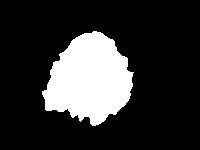</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [2]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [3]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
!unzip -q /content/gdrive/MyDrive/PH2Dataset.zip

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
import os
from skimage.io import imread
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root)):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

os.path.join(root)

'PH2Dataset/PH2 Dataset images/IMD390/IMD390_Dermoscopic_Image'

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False)
     > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

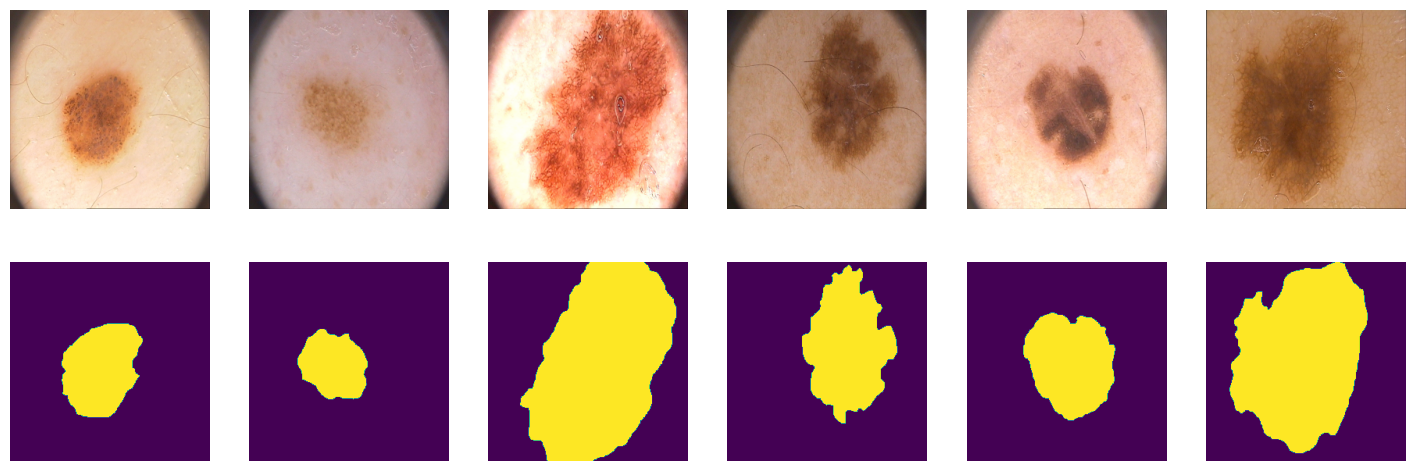

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()


Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
# Только индексы
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [13]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

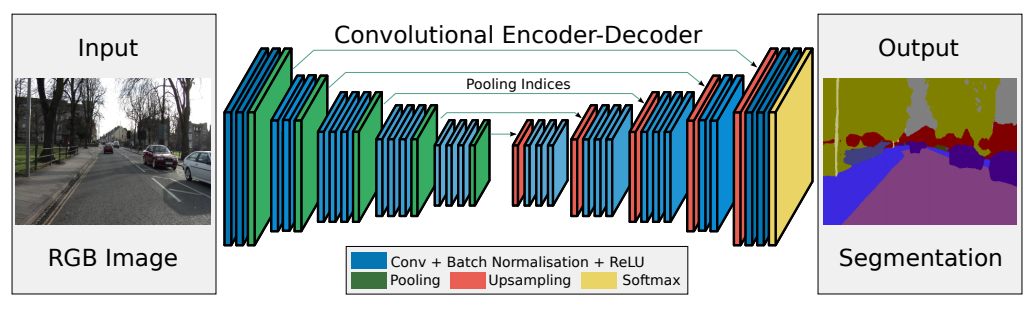

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

**Приведу некоторое описание архитектуры SegNet-Basic из оригинальной статьи:**
- There are no fully connected layers and hence it is only convolutional  
- A constant kernel size of 7 × 7 over all the encoder and decoder layers is chosen   
***Encoder**  
- The encoder network consists of 13 convolutional layers  
- These are then batch normalized  
- Then an element-wise ReLU is applied  
- Max-pooling with a 2 × 2 window and stride 2 is performed  
***Bottleneck**  
- The resulting output is sub-sampled by a factor of 2  
***Decoder**
-  A decoder upsamples its input using the memorized max-pooling indices from its encoder  
- These feature maps are then convolved with a trainable decoder filter  
- A batch normalization step is then applied to each of these maps  
- No biases are used after convolutions and no ReLU nonlinearity is present in the decoder network.  
  
Учтем эти дополнения за исключением того, что сверточные фильтры возьмем меньшего размера 3х3 вместо 7×7.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)


In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)   # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.bottle_pool = nn.MaxPool2d(2, 2, return_indices=True)

        self.bottle_unpool = nn.MaxUnpool2d(2, 2)

        self.bottleneck_conv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256, affine=False),
            #nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, 2)    # 16 -> 32
        self.dec_conv0 =  nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=False),
            #nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(2, 2)    # 32 -> 64
        self.dec_conv1 =  nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=False),
            #nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(2, 2)    # 64 -> 128
        self.dec_conv2 =  nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32, affine=False),
            #nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(2, 2)    # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32, affine=False),
            #nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1, affine=False),
            #nn.ReLU(),
        )


    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b, ind4 = self.bottle_pool(self.bottleneck_conv1(e3))
        b = self.bottleneck_conv2(self.bottle_unpool(b, ind4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1,ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0)) # no activation
        return d3


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum(
        (1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum(
        (1, 2))         # Will be zero if both are 0

    # We smooth our devision to avoid 0/0
    iou = (intersection + SMOOTH) / (union + SMOOTH)

    # This is equal to comparing with thresolds
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded


## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))
    return loss.mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, score_model, data_tr, data_val):

    losses_train = []
    losses_val = []
    scores_train = []
    scores_val = []

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to DEVICE
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()                 # backward-pass
            opt.step()                      # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        print('train loss: %f' % avg_loss)
        losses_train.append(avg_loss.tolist())

        # show intermediate results
        model.eval()  # testing mode

        avg_score_train = score_model(model, iou_pytorch, data_tr, DEVICE)
        scores_train.append(avg_score_train)

        # val loss
        avg_loss_val = 0
        for X_val, Y_val in data_val:
            with torch.no_grad():
                Y_hat = model(X_val.to(DEVICE)).detach().cpu()# detach and put into cpu

                loss = loss_fn(Y_val, Y_hat) # forward-pass
                avg_loss_val += loss / len(data_val)

        print('val_loss: %f' % avg_loss_val)
        losses_val.append(avg_loss_val.tolist())

        # val score
        avg_score_val = score_model(model, iou_pytorch, data_val, DEVICE)
        scores_val.append(avg_score_val)

    return (losses_train, losses_val, scores_train, scores_val)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [21]:
def score_model(model, metric, data, device):
    model.eval()  # testing mode
    torch.cuda.empty_cache()
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        # логиты > 0, т.е. при p>0.5
        Y_pred = (Y_pred > 0).type(torch.long)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [22]:
torch.cuda.empty_cache()

model_bce = SegNet().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_bce.parameters(), lr=0.001, weight_decay=0.05)
history_bce = train(model_bce, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

* Epoch 1/50
train loss: 0.647307
val_loss: 0.671912
* Epoch 2/50
train loss: 0.482520
val_loss: 1.268568
* Epoch 3/50
train loss: 0.459396
val_loss: 1.657922
* Epoch 4/50
train loss: 0.429899
val_loss: 1.599687
* Epoch 5/50
train loss: 0.433091
val_loss: 1.049909
* Epoch 6/50
train loss: 0.441275
val_loss: 0.549036
* Epoch 7/50
train loss: 0.422818
val_loss: 0.486660
* Epoch 8/50
train loss: 0.425679
val_loss: 0.411584
* Epoch 9/50
train loss: 0.432648
val_loss: 0.460625
* Epoch 10/50
train loss: 0.430555
val_loss: 0.393299
* Epoch 11/50
train loss: 0.417379
val_loss: 0.393984
* Epoch 12/50
train loss: 0.413488
val_loss: 0.417437
* Epoch 13/50
train loss: 0.414735
val_loss: 0.463633
* Epoch 14/50
train loss: 0.414799
val_loss: 0.423155
* Epoch 15/50
train loss: 0.416084
val_loss: 0.459826
* Epoch 16/50
train loss: 0.407128
val_loss: 0.448119
* Epoch 17/50
train loss: 0.408397
val_loss: 0.508520
* Epoch 18/50
train loss: 0.403163
val_loss: 0.501736
* Epoch 19/50
train loss: 0.405233
va

In [23]:
print('IoU metric:')
score_model(model_bce, iou_pytorch, data_val, DEVICE)

IoU metric:


0.4479999989271164

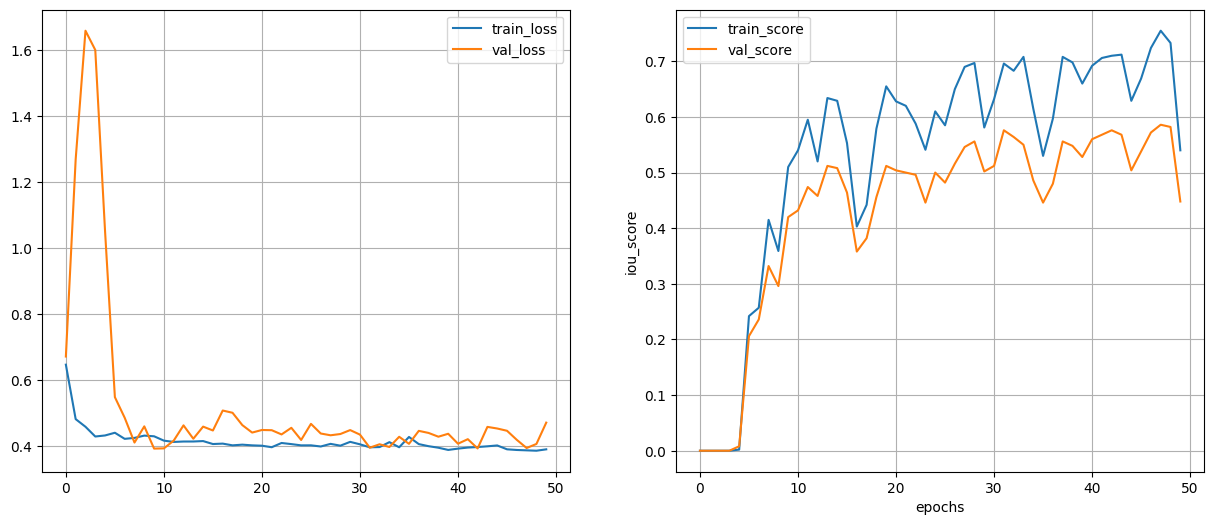

In [24]:
def plot_results(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6
                                            ))
    axes[0].plot(history[0], label="train_loss")
    axes[0].plot(history[1], label="val_loss")
    axes[0].grid()
    axes[0].legend()

    axes[1].plot(history[2], label="train_score")
    axes[1].plot(history[3], label="val_score")
    axes[1].grid()
    axes[1].legend()
    plt.xlabel("epochs")
    plt.ylabel("iou_score")
    plt.show()

plot_results(history_bce)

Если сравнивать изменение качества работы модели по IoU-score, то эта метрика во время обучения заметно ниже для валидационных данных, что скорее говорит о переобучении.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = y_pred.sigmoid().squeeze(1)
    y_real = y_real.squeeze(1)

    num = (y_pred * y_real).sum()
    den = (y_pred + y_real).sum()
    # We smooth our devision to avoid 0/0
    res = 1 - ((2. * num + SMOOTH) / (den + SMOOTH)) / (256*256)

    return res

Проводим тестирование:

* Epoch 1/50
train loss: 0.999994
val_loss: 0.999994
* Epoch 2/50
train loss: 0.999991
val_loss: 0.999994
* Epoch 3/50
train loss: 0.999991
val_loss: 0.999994
* Epoch 4/50
train loss: 0.999991
val_loss: 0.999994
* Epoch 5/50
train loss: 0.999991
val_loss: 0.999994
* Epoch 6/50
train loss: 0.999991
val_loss: 0.999995
* Epoch 7/50
train loss: 0.999991
val_loss: 0.999994
* Epoch 8/50
train loss: 0.999991
val_loss: 0.999993
* Epoch 9/50
train loss: 0.999991
val_loss: 0.999992
* Epoch 10/50
train loss: 0.999991
val_loss: 0.999992
* Epoch 11/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 12/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 13/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 14/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 15/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 16/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 17/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 18/50
train loss: 0.999991
val_loss: 0.999991
* Epoch 19/50
train loss: 0.999991
va

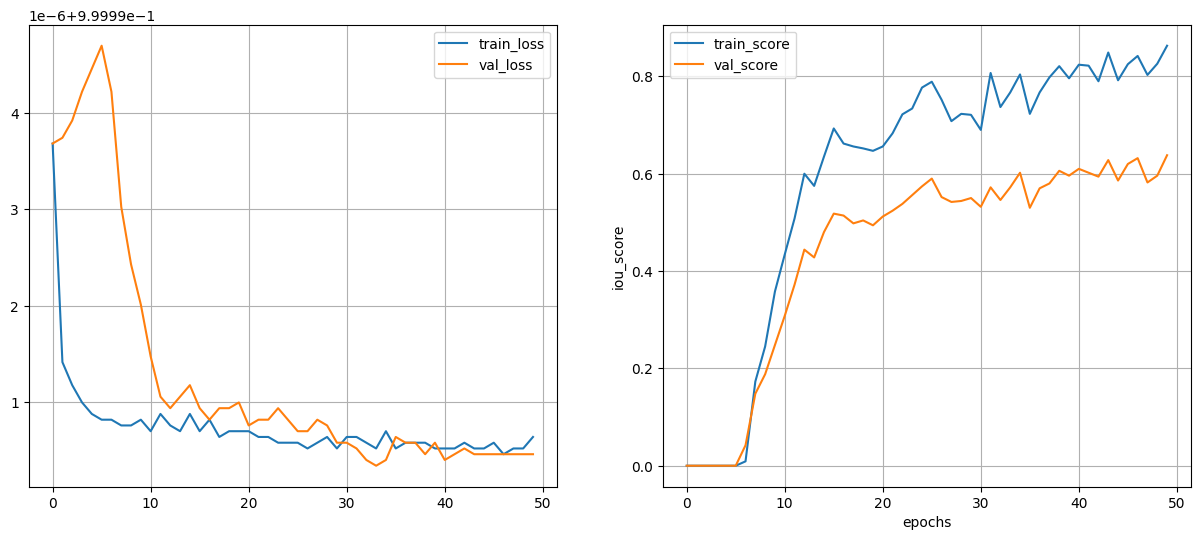

IoU metric:
0.6380000114440918


In [26]:
torch.cuda.empty_cache()

model_dice = SegNet().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_dice.parameters(), lr=0.001, weight_decay=0.05)
history_dice = train(model_dice, optimizer, dice_loss, max_epochs, score_model, data_tr, data_val)

plot_results(history_dice)
print('IoU metric:')
print(score_model(model_dice, iou_pytorch, data_val, DEVICE))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [27]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)

    loss = -torch.mean(
        ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(
        1 - torch.sigmoid(y_pred) + eps))
    return loss

* Epoch 1/50
train loss: 0.634103
val_loss: 0.508242
* Epoch 2/50
train loss: 0.486773
val_loss: 0.453549
* Epoch 3/50
train loss: 0.379629
val_loss: 0.492359
* Epoch 4/50
train loss: 0.380188
val_loss: 0.871892
* Epoch 5/50
train loss: 0.359025
val_loss: 0.758450
* Epoch 6/50
train loss: 0.356765
val_loss: 0.433284
* Epoch 7/50
train loss: 0.346074
val_loss: 0.832943
* Epoch 8/50
train loss: 0.347033
val_loss: 0.337525
* Epoch 9/50
train loss: 0.341463
val_loss: 0.361583
* Epoch 10/50
train loss: 0.342492
val_loss: 0.305815
* Epoch 11/50
train loss: 0.336414
val_loss: 0.320038
* Epoch 12/50
train loss: 0.334285
val_loss: 0.302132
* Epoch 13/50
train loss: 0.333337
val_loss: 0.315109
* Epoch 14/50
train loss: 0.345895
val_loss: 0.303681
* Epoch 15/50
train loss: 0.335121
val_loss: 0.309699
* Epoch 16/50
train loss: 0.330208
val_loss: 0.311755
* Epoch 17/50
train loss: 0.330911
val_loss: 0.315163
* Epoch 18/50
train loss: 0.329789
val_loss: 0.321953
* Epoch 19/50
train loss: 0.339619
va

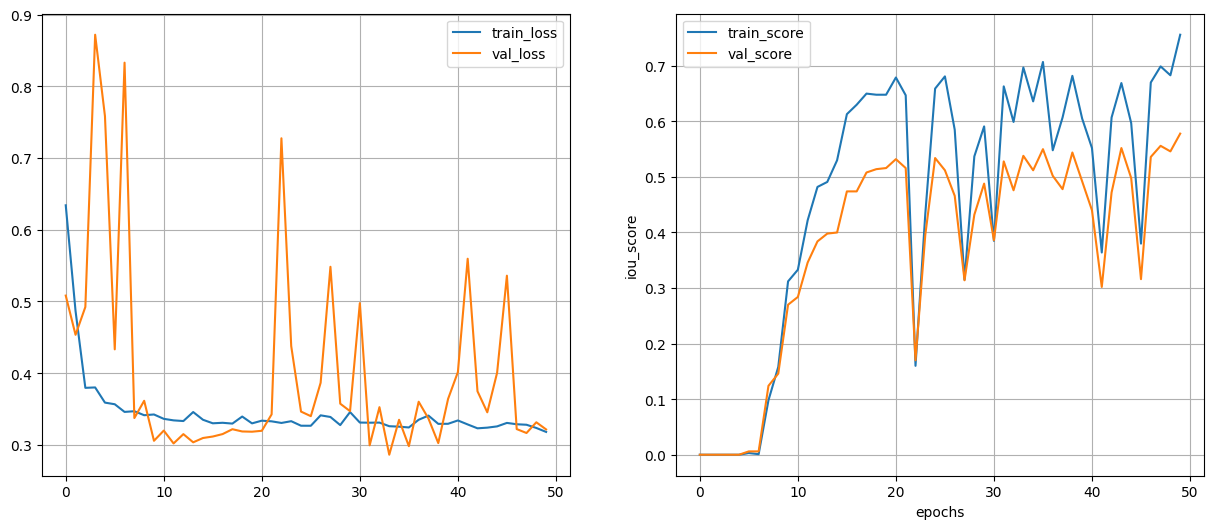

IoU metric:
0.578000009059906


In [28]:
torch.cuda.empty_cache()

model_focal = SegNet().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_focal.parameters(), lr=0.001, weight_decay=0.05)
history_focal = train(model_focal, optimizer, focal_loss, max_epochs, score_model, data_tr, data_val)

plot_results(history_focal)
print('IoU metric:')
print(score_model(model_focal, iou_pytorch, data_val, DEVICE))

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation  
2) Lova  
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)  
4) Любой другой  

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [29]:
# Structural Similarity Loss

def similar_loss(y_real, y_pred):
    y_real = torch.flatten(y_real)
    y_pred = torch.flatten(y_pred)

    smooth = 1e-8

    y_real = y_real - torch.mean(y_real)
    y_pred = y_pred - torch.mean(y_pred)
    loss = ((y_real - y_pred) ** 2) / (y_real ** 2 + y_pred ** 2 + (len(y_real) - 1) * smooth)
    return torch.mean(loss)

In [30]:
# Лосс с регуляризацией по выходным предсказаниям
# Эта функция выдумана мной)))

def reg_bce_loss(y_real, y_pred, alpha=0.1):

    reg_loss = alpha * (y_pred ** 2).mean()
    loss = bce_loss(y_real, y_pred) + reg_loss
    return loss.mean()

* Epoch 1/50
train loss: 0.871894
val_loss: 0.930672
* Epoch 2/50
train loss: 0.400466
val_loss: 1.050890
* Epoch 3/50
train loss: 0.292991
val_loss: 1.035564
* Epoch 4/50
train loss: 0.246605
val_loss: 1.059189
* Epoch 5/50
train loss: 0.246082
val_loss: 1.046922
* Epoch 6/50
train loss: 0.210038
val_loss: 0.975269
* Epoch 7/50
train loss: 0.202539
val_loss: 0.935645
* Epoch 8/50
train loss: 0.209791
val_loss: 0.858241
* Epoch 9/50
train loss: 0.188842
val_loss: 0.731858
* Epoch 10/50
train loss: 0.170216
val_loss: 0.646914
* Epoch 11/50
train loss: 0.173455
val_loss: 0.455742
* Epoch 12/50
train loss: 0.179341
val_loss: 0.356306
* Epoch 13/50
train loss: 0.179544
val_loss: 0.426856
* Epoch 14/50
train loss: 0.193177
val_loss: 0.454303
* Epoch 15/50
train loss: 0.192774
val_loss: 0.634603
* Epoch 16/50
train loss: 0.261320
val_loss: 0.299849
* Epoch 17/50
train loss: 0.220671
val_loss: 0.293121
* Epoch 18/50
train loss: 0.185409
val_loss: 0.273984
* Epoch 19/50
train loss: 0.177294
va

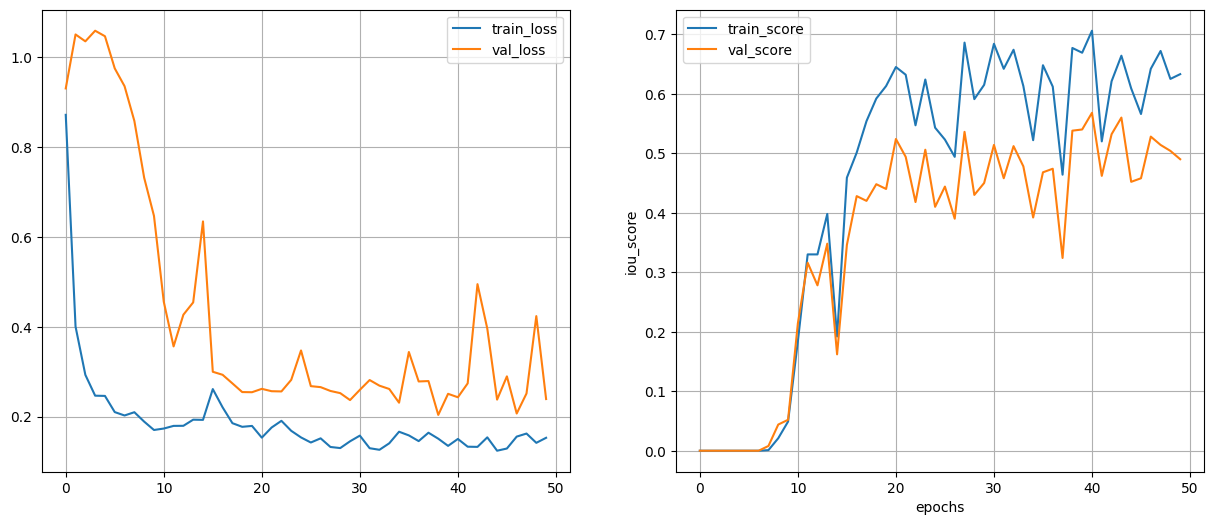

IoU metric:
0.49000002443790436


In [31]:
torch.cuda.empty_cache()

model_similar = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_similar.parameters(), lr=0.001, weight_decay=0.05)
history_similar = train(model_similar, optimizer, similar_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_similar)
print('IoU metric:')
print(score_model(model_similar, iou_pytorch, data_val, DEVICE))

* Epoch 1/50
train loss: 0.790659
val_loss: 0.682257
* Epoch 2/50
train loss: 0.620745
val_loss: 1.227434
* Epoch 3/50
train loss: 0.565482
val_loss: 1.546691
* Epoch 4/50
train loss: 0.555016
val_loss: 1.000455
* Epoch 5/50
train loss: 0.550489
val_loss: 2.230083
* Epoch 6/50
train loss: 0.528554
val_loss: 1.490918
* Epoch 7/50
train loss: 0.533094
val_loss: 1.341713
* Epoch 8/50
train loss: 0.527835
val_loss: 1.078729
* Epoch 9/50
train loss: 0.519581
val_loss: 0.830895
* Epoch 10/50
train loss: 0.514240
val_loss: 0.704884
* Epoch 11/50
train loss: 0.512842
val_loss: 0.650366
* Epoch 12/50
train loss: 0.523144
val_loss: 0.589885
* Epoch 13/50
train loss: 0.513594
val_loss: 0.575402
* Epoch 14/50
train loss: 0.528559
val_loss: 0.557331
* Epoch 15/50
train loss: 0.514734
val_loss: 0.544894
* Epoch 16/50
train loss: 0.519135
val_loss: 0.534522
* Epoch 17/50
train loss: 0.516428
val_loss: 0.534719
* Epoch 18/50
train loss: 0.506453
val_loss: 0.542651
* Epoch 19/50
train loss: 0.506637
va

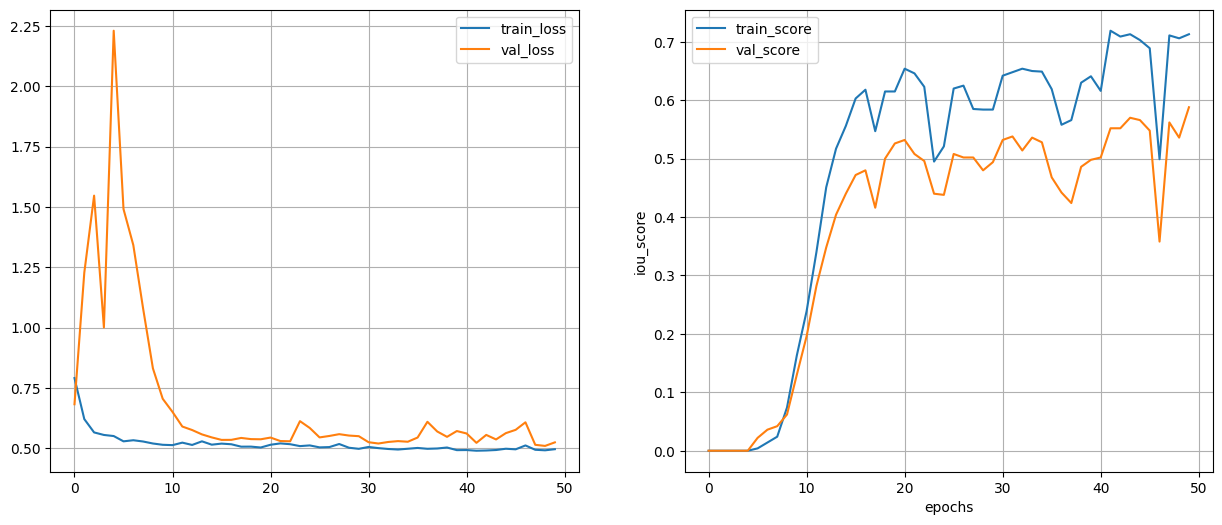

IoU metric:
0.5880000293254852


In [32]:
torch.cuda.empty_cache()

model_bcereg = SegNet().to(DEVICE)

max_epochs = 50

optimizer = torch.optim.AdamW(model_bcereg.parameters(), lr=0.001, weight_decay=0.05)
history_reg = train(model_bcereg, optimizer, reg_bce_loss, max_epochs, score_model, data_tr, data_val)
plot_results(history_reg)
print('IoU metric:')
print(score_model(model_bcereg, iou_pytorch, data_val, DEVICE))

In [33]:
import gc
gc.collect()
plt.close('all')
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

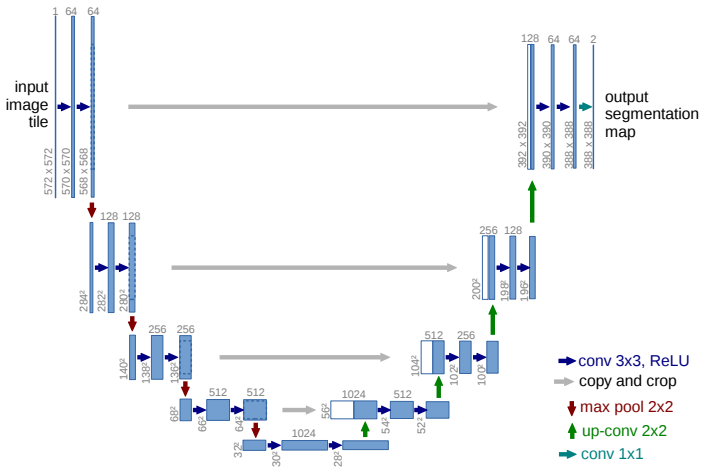

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [34]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(2, 2)    # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)    # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)    # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)    # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(         # 16 -> 32
            nn.Upsample(32),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.upsample1 = nn.Sequential(         # 32 -> 64
            nn.Upsample(64),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample2 = nn.Sequential(         # 64 -> 128
            nn.Upsample(128),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample3 = nn.Sequential(         # 128 -> 256
            nn.Upsample(256),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.ReLU(),
        )

    def forward(self, x):
        # encoder
        e01 = self.enc_conv0(x)
        e02 = self.pool0(e01)
        e11 = self.enc_conv1(e02)
        e12 = self.pool1(e11)
        e21 = self.enc_conv2(e12)
        e22 = self.pool2(e21)
        e31 = self.enc_conv3(e22)
        e32 = self.pool3(e31)

        # bottleneck
        b = self.bottleneck_conv(e32)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0, e31), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1, e21), dim=1))
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2, e11), dim=1))
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3, e01), dim=1))

        return d3

* Epoch 1/50
train loss: 0.670081
val_loss: 0.693147
* Epoch 2/50
train loss: 0.633508
val_loss: 0.693147
* Epoch 3/50
train loss: 0.600406
val_loss: 0.693147
* Epoch 4/50
train loss: 0.589124
val_loss: 0.693147
* Epoch 5/50
train loss: 0.583565
val_loss: 0.693147
* Epoch 6/50
train loss: 0.582536
val_loss: 0.690619
* Epoch 7/50
train loss: 0.574629
val_loss: 0.626693
* Epoch 8/50
train loss: 0.565980
val_loss: 0.599972
* Epoch 9/50
train loss: 0.565403
val_loss: 0.616828
* Epoch 10/50
train loss: 0.564704
val_loss: 0.565061
* Epoch 11/50
train loss: 0.552771
val_loss: 0.602137
* Epoch 12/50
train loss: 0.550607
val_loss: 0.570157
* Epoch 13/50
train loss: 0.571512
val_loss: 0.547613
* Epoch 14/50
train loss: 0.555446
val_loss: 0.692803
* Epoch 15/50
train loss: 0.557676
val_loss: 0.555239
* Epoch 16/50
train loss: 0.555312
val_loss: 0.559741
* Epoch 17/50
train loss: 0.557638
val_loss: 0.562987
* Epoch 18/50
train loss: 0.552605
val_loss: 0.544399
* Epoch 19/50
train loss: 0.543396
va

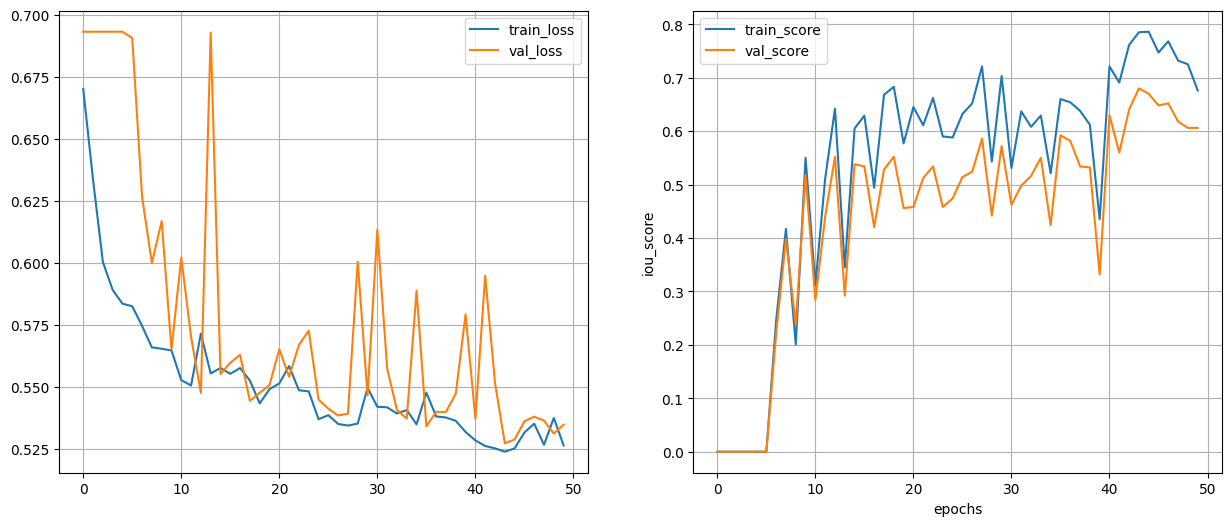

IoU metric:
0.6060000061988831


In [35]:
model_unet = UNet().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=0.001, weight_decay=0.05)
history_unet = train(model_unet, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

plot_results(history_unet)
print('IoU metric:')
print(score_model(model_unet, iou_pytorch, data_val, DEVICE))


In [36]:
gc.collect()
plt.close('all')
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.



In [52]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)

        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)

        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)

        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))

        return d3

* Epoch 1/50
train loss: 0.603599
val_loss: 0.684738
* Epoch 2/50
train loss: 0.410769
val_loss: 0.652147
* Epoch 3/50
train loss: 0.377579
val_loss: 0.593375
* Epoch 4/50
train loss: 0.352579
val_loss: 0.547541
* Epoch 5/50
train loss: 0.329000
val_loss: 0.523568
* Epoch 6/50
train loss: 0.313270
val_loss: 0.518335
* Epoch 7/50
train loss: 0.344209
val_loss: 0.522333
* Epoch 8/50
train loss: 0.309656
val_loss: 0.515786
* Epoch 9/50
train loss: 0.292801
val_loss: 0.473955
* Epoch 10/50
train loss: 0.264543
val_loss: 0.458589
* Epoch 11/50
train loss: 0.271714
val_loss: 0.344914
* Epoch 12/50
train loss: 0.248727
val_loss: 0.361550
* Epoch 13/50
train loss: 0.238823
val_loss: 0.355642
* Epoch 14/50
train loss: 0.232676
val_loss: 0.940111
* Epoch 15/50
train loss: 0.222309
val_loss: 0.314028
* Epoch 16/50
train loss: 0.213407
val_loss: 0.301691
* Epoch 17/50
train loss: 0.211086
val_loss: 0.302040
* Epoch 18/50
train loss: 0.216455
val_loss: 0.296718
* Epoch 19/50
train loss: 0.210261
va

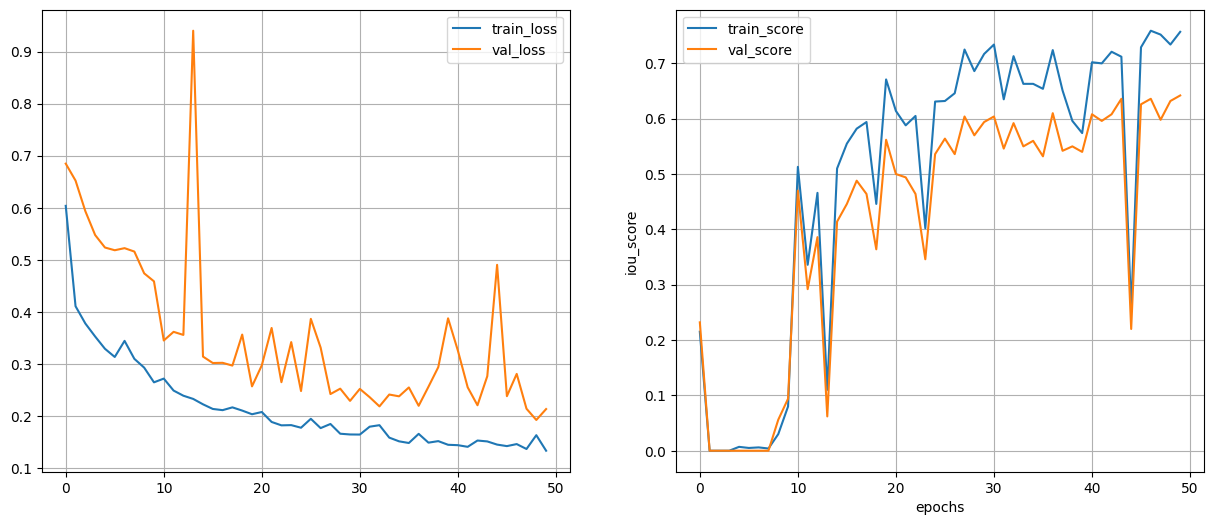

IoU metric:
0.6419999897480011


In [53]:
model_unet2 = UNet2().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_unet2.parameters(), lr=0.001, weight_decay=0.05)
history_unet2 = train(model_unet2, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

plot_results(history_unet2)
print('IoU metric:')
print(score_model(model_unet2, iou_pytorch, data_val, DEVICE))

In [54]:
gc.collect()
plt.close('all')
torch.cuda.empty_cache()

Следующая архитектура U-Net2 отличается от предыдущей тем, что в пулинг-слое (слое для сжатия фото в 2 раза) добавлен padding=1. То есть  
```self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)```  
заменено на  
```self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)```  
От этого модель не учится и лучше так не делать. В отчете эта архитектура не рассматривается.

In [40]:
class UNet2(nn.Module):
      def __init__(self):
          super().__init__()

          self.enc_conv0 = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
              nn.Conv2d(64, 64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(),
          )
          self.pool0 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)    # 256 -> 128
          self.enc_conv1 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(128, 128, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.pool1 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 128 -> 64
          self.enc_conv2 = nn.Sequential(
              nn.Conv2d(128, 256, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(256, 256, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.pool2 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)  # 64 -> 32
          self.enc_conv3 = nn.Sequential(
              nn.Conv2d(256, 512, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(512, 512, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.pool3 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)  # 32 -> 16

          # bottleneck
          self.bottleneck_conv = nn.Sequential(
              nn.Conv2d(512, 1024, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
              nn.ReLU(),
          )

          # decoder (upsampling)
          self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 16 -> 32
          self.dec_conv0 = nn.Sequential(
              nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(512, 512, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 32 -> 64
          self.dec_conv1 = nn.Sequential(
              nn.Conv2d(256 * 2, 256, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(256, 256, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 64 -> 128
          self.dec_conv2 = nn.Sequential(
              nn.Conv2d(128 * 2, 128, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(128, 128, kernel_size=3, padding=1),
              nn.ReLU(),
          )
          self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # 128 -> 256
          self.dec_conv3 = nn.Sequential(
              nn.Conv2d(64 * 2, 64, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(64, 64, kernel_size=3, padding=1),
              nn.ReLU(),
              nn.Conv2d(64, 1, kernel_size=1),
              nn.ReLU(),
          )

      def forward(self, x):
            # encoder
            e01 = self.enc_conv0(x)
            e02 = self.pool0(e01)
            e11 = self.enc_conv1(e02)
            e12 = self.pool1(e11)
            e21 = self.enc_conv2(e12)
            e22 = self.pool2(e21)
            e31 = self.enc_conv3(e22)
            e32 = self.pool3(e31)

            # bottleneck
            b = self.bottleneck_conv(e32)

            # decoder
            d0 = self.upsample0(b)
            d0 = self.dec_conv0(torch.cat((d0, e31), dim = 1))
            d1 = self.upsample1(d0)
            d1 = self.dec_conv1(torch.cat((d1, e21), dim = 1))
            d2 = self.upsample2(d1)
            d2 = self.dec_conv2(torch.cat((d2, e11), dim = 1))
            d3 = self.upsample3(d2)
            d3 = self.dec_conv3(torch.cat((d3, e01), dim = 1))

            return d3

* Epoch 1/50
train loss: 0.670116
val_loss: 0.693145
* Epoch 2/50
train loss: 0.634026
val_loss: 0.693147
* Epoch 3/50
train loss: 0.632022
val_loss: 0.693147
* Epoch 4/50
train loss: 0.597293
val_loss: 0.689737
* Epoch 5/50
train loss: 0.594542
val_loss: 0.687512
* Epoch 6/50
train loss: 0.589643
val_loss: 0.683958
* Epoch 7/50
train loss: 0.587767
val_loss: 0.681642
* Epoch 8/50
train loss: 0.583040
val_loss: 0.676379
* Epoch 9/50
train loss: 0.584991
val_loss: 0.658202
* Epoch 10/50
train loss: 0.576949
val_loss: 0.636879
* Epoch 11/50
train loss: 0.593696
val_loss: 0.633217
* Epoch 12/50
train loss: 17.742012
val_loss: 0.655477
* Epoch 13/50
train loss: 0.633191
val_loss: 0.671132
* Epoch 14/50
train loss: 0.665320
val_loss: 0.667217
* Epoch 15/50
train loss: 0.678772
val_loss: 0.693075
* Epoch 16/50
train loss: 0.690403
val_loss: 0.693147
* Epoch 17/50
train loss: 0.693147
val_loss: 0.693147
* Epoch 18/50
train loss: 0.693147
val_loss: 0.693147
* Epoch 19/50
train loss: 0.693147
v

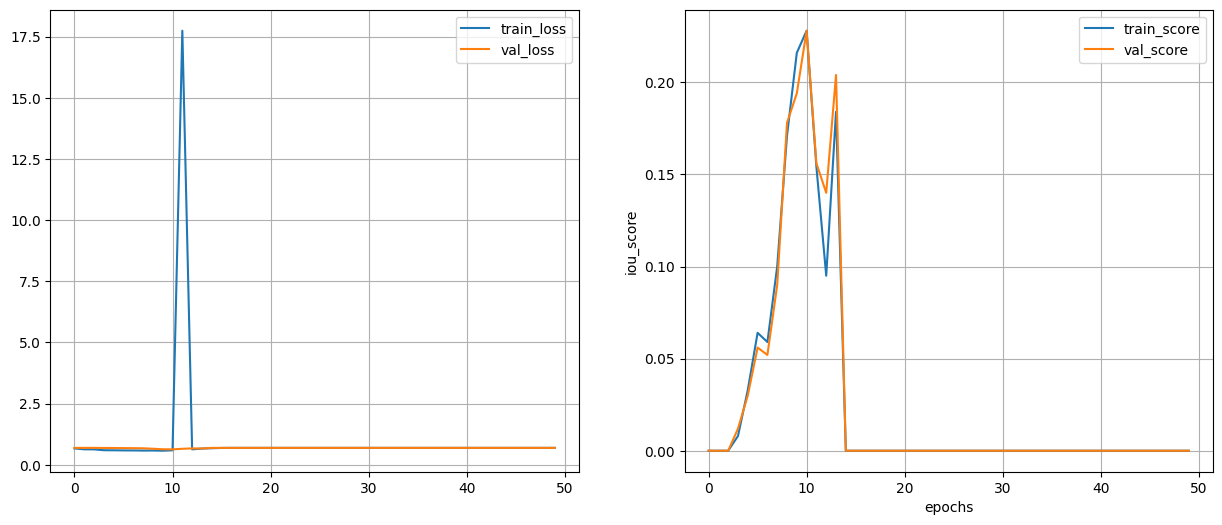

IoU metric:
0.0


In [41]:
model_unet2 = UNet2().to(DEVICE)

max_epochs = 50
optimizer = torch.optim.AdamW(model_unet2.parameters(), lr=0.001, weight_decay=0.05)
history_unet2 = train(model_unet2, optimizer, bce_loss, max_epochs, score_model, data_tr, data_val)

plot_results(history_unet2)
print('IoU metric:')
print(score_model(model_unet2, iou_pytorch, data_val, DEVICE))

In [43]:
gc.collect()
plt.close('all')
torch.cuda.empty_cache()

Выберем U-net2 в качестве лучшей модели по IoU-score (64 %) на валидационном сете.

# Отчет (6 баллов):

В этой работе главным образом необходимо было разобраться, как устроены архитектуры нейросетей для сегментации изображений, а также понять специфику функций потерь для задачи сегментации. Для достижения данной цели были поставлены **задачи**:  
- Сравнить результативность определенной нейросети при варьировании различных лосс-функций.  
- Сравнить результативность нескольких различных архитекутур нейросетей при фиксированной функции потерь.  
  
В качестве архитектур сверточных сетей были реализованы модели с блоками энкодера и декодера:  
  - **SegNet**  
  - **U-Net**  

В качестве функций потерь рассматривались:  
  - упрощенная бинарная кросс-энтропия **BCE**  
  - коэффициент **Dice**  
  - **Focal loss**  
  - Structural Similarity Loss **SSIM**  
  - BCE с регуляризацией  

Итак, посмотрим как менялись потери и оценка качества по IoU в ходе обучения у модели SegNet в зависимости от типа лосс-функции.

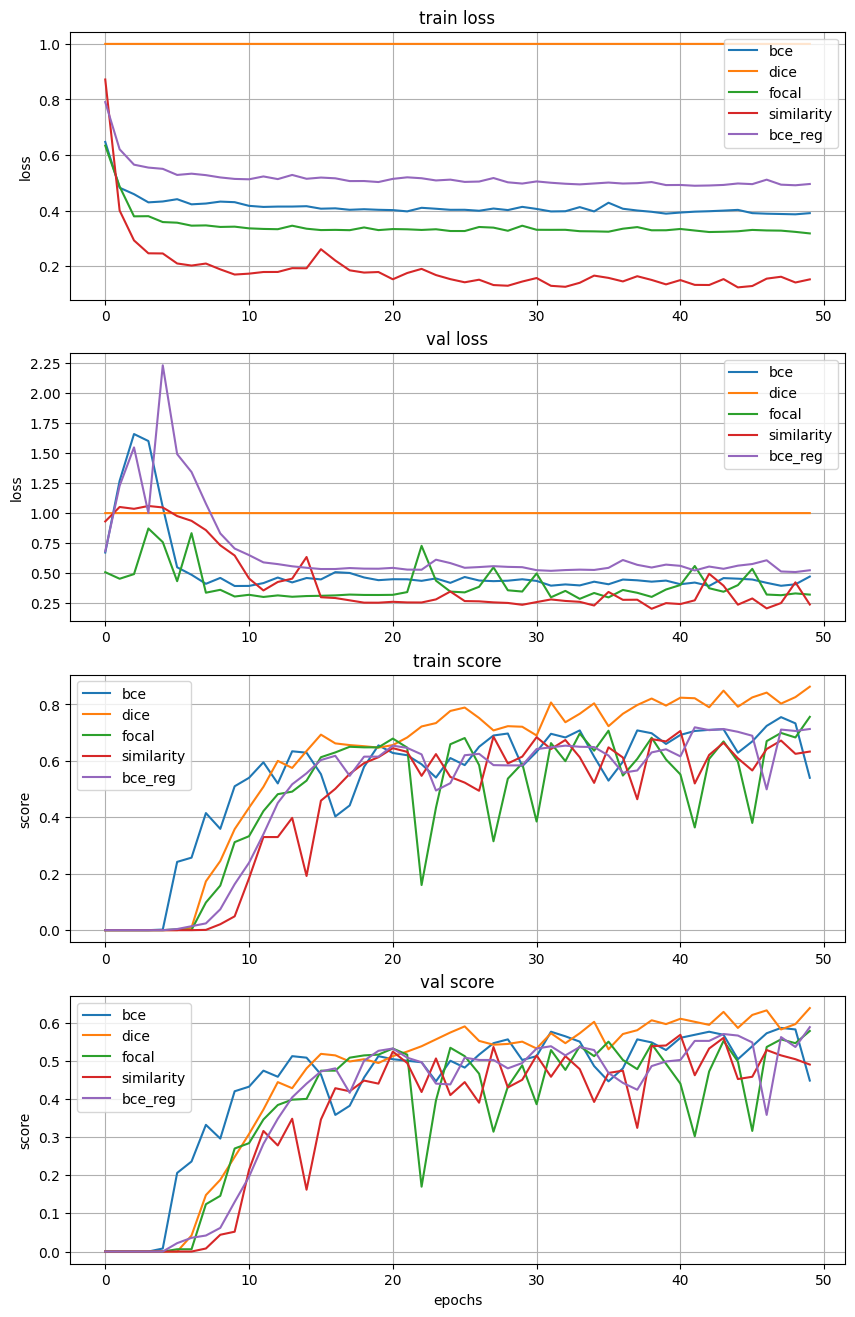

In [55]:
history = [
    history_bce,
    history_dice,
    history_focal,
    history_similar,
    history_reg,
    ]

name = [
    'bce',
    'dice',
    'focal',
    'similarity',
    'bce_reg',
]

fig, axes = plt.subplots(4, 1, figsize=(10, 16))
for i, hist in enumerate(history):
    axes[0].plot(hist[0], label=f"{name[i]}")
    axes[0].grid()
    axes[0].set_title('train loss')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].plot(hist[1], label=f"{name[i]}")
    axes[1].grid()
    axes[1].set_title('val loss')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    axes[2].plot(hist[2], label=f"{name[i]}")
    axes[2].grid()
    axes[2].set_title('train score')
    axes[2].set_ylabel('score')
    axes[2].legend()

    axes[3].plot(hist[3], label=f"{name[i]}")
    axes[3].grid()
    axes[3].set_title('val score')
    axes[3].set_ylabel('score')
    axes[3].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")

plt.show()

У большинства примененных лосс-функций наблюдаются сильные колебания функций потерь и метрик на обучающей и тестовой выборках в течение эпох обучения. Возможно причина кроется в маленьком количестве данных для обучения при относительно сложной архитектуре модели. Решить проблему могли бы аугментация данных, кросс-валидация, а также инициализация весами предобученной модели.  
  
Сравним качество инференса моделей на валидационной и отложенной тестовой выборках.

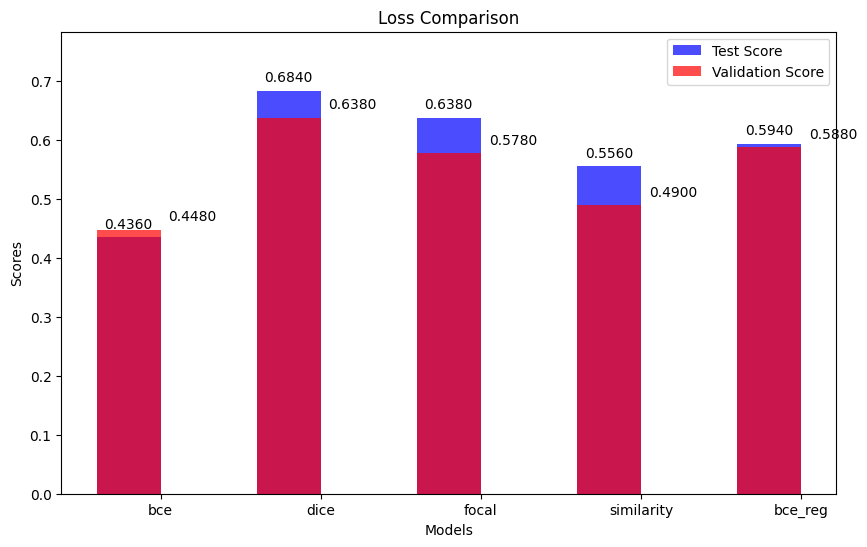

In [56]:
model_list = [
    model_bce,
    model_dice,
    model_focal,
    model_similar,
    model_bcereg,
]

name = [
    'bce',
    'dice',
    'focal',
    'similarity',
    'bce_reg',
]

scores = []
scores_val = []

for i, model in enumerate(model_list):
    score = score_model(model, iou_pytorch, data_ts, DEVICE)
    score_val = score_model(model, iou_pytorch, data_val, DEVICE)
    scores.append(score)
    scores_val.append(score_val)

plt.figure(figsize=(10, 6))
plt.bar(name, scores, alpha=0.7, label='Test Score', color='b', width=0.4)
plt.bar(name, scores_val, alpha=0.7, label='Validation Score', color='r', width=0.4)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Loss Comparison')
plt.xticks([x + 0.2 for x in range(len(name))], name)
plt.ylim(0, max(max(scores), max(scores_val)) + 0.1)
plt.legend()
for i in range(len(name)):
    plt.text(i, scores[i] + 0.01, f"{scores[i]:.4f}", ha='center', va='bottom')
    plt.text(i + 0.4, scores_val[i] + 0.01, f"{scores_val[i]:.4f}", ha='center', va='bottom')
plt.show()

Из диаграмм видно, что лучший результат показывает модель с Dice loss. Её IoU-score составляет 64 % на валидационных данных и 68 % на тестовых данных.

Сравним реализации:  
SegNet (использует MaxPool - MaxUnPool),  
U-Net (использует MaxPool - Upsample),  
U-Net-2 (использует Convolution - ConvTranspose)

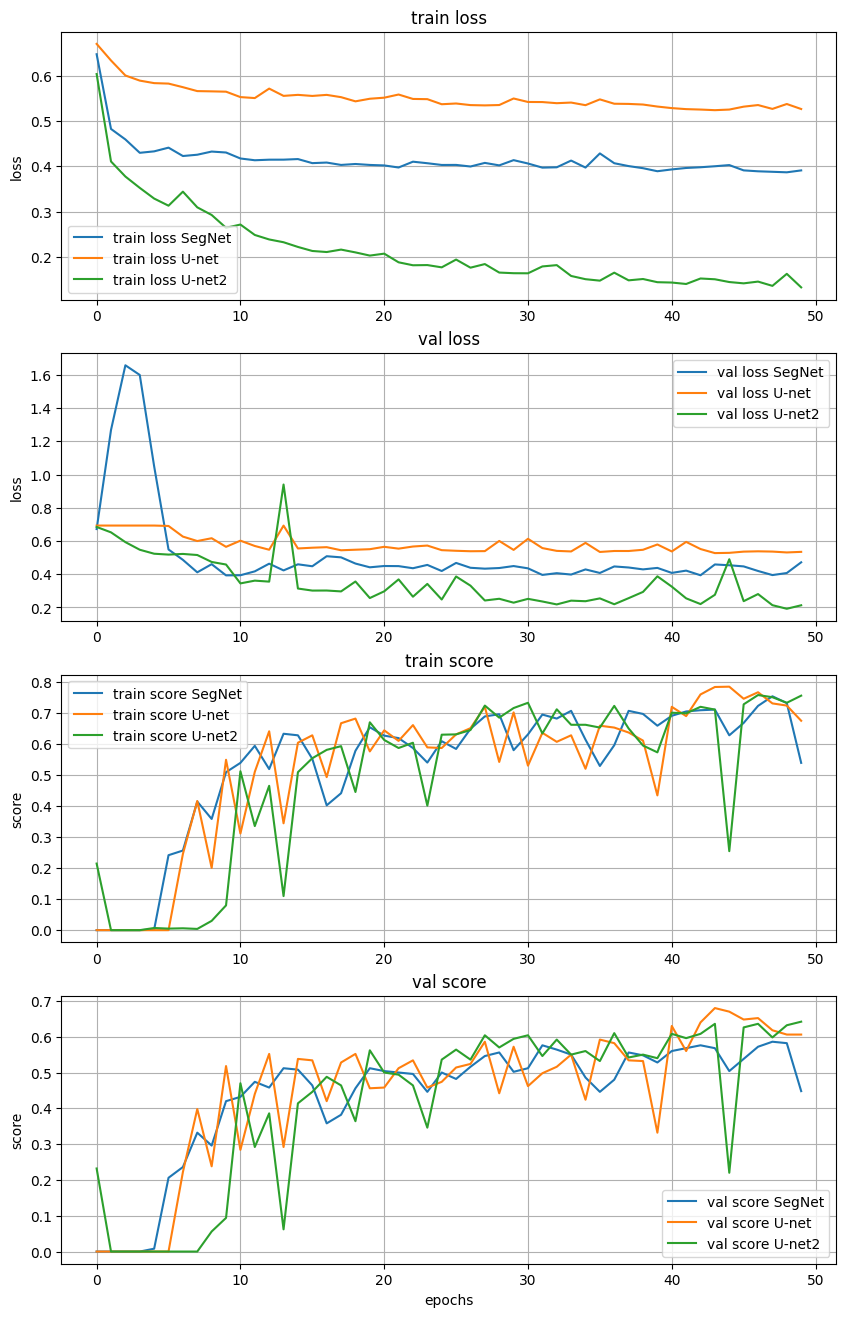

In [58]:
history = [
    history_bce,
    history_unet,
    history_unet2,
]
name = [
    'SegNet',
    'U-net',
    'U-net2',
]

fig, axes = plt.subplots(4, 1, figsize=(10, 16))
for i, hist in enumerate(history):
    axes[0].plot(hist[0], label=f"train loss {name[i]}")
    axes[0].grid()
    axes[0].set_title('train loss')
    axes[0].set_ylabel('loss')
    axes[0].legend()

    axes[1].plot(hist[1], label=f"val loss {name[i]}")
    axes[1].grid()
    axes[1].set_title('val loss')
    axes[1].set_ylabel('loss')
    axes[1].legend()

    axes[2].plot(hist[2], label=f"train score {name[i]}")
    axes[2].grid()
    axes[2].set_title('train score')
    axes[2].set_ylabel('score')
    axes[2].legend()

    axes[3].plot(hist[3], label=f"val score {name[i]}")
    axes[3].grid()
    axes[3].set_title('val score')
    axes[3].set_ylabel('score')
    axes[3].legend()
    plt.xlabel("epochs")
    plt.ylabel("score")

plt.show()

*Примечание. Функция потерь на графиках везде одинаковая (BCE loss).*

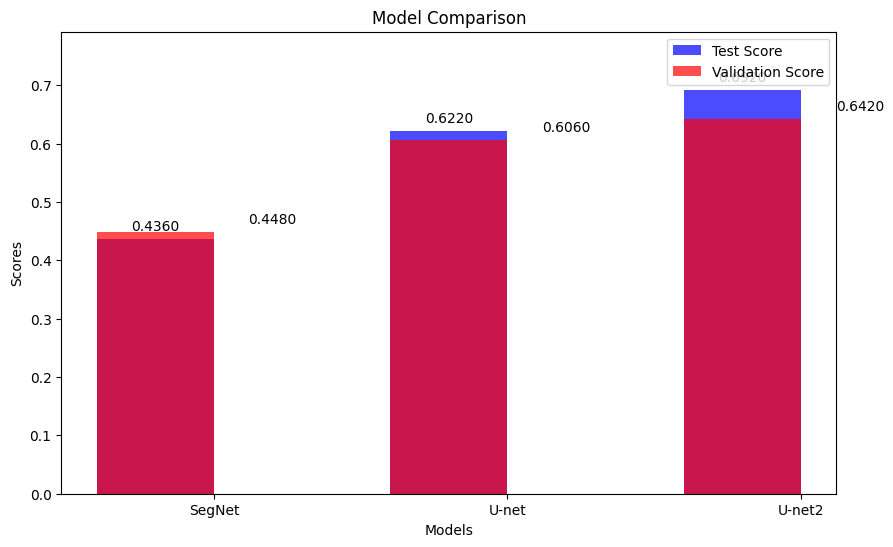

In [61]:
model_list = [
    model_bce,
    model_unet,
    model_unet2,
]

name = [
    'SegNet',
    'U-net',
    'U-net2',
]

scores = []
scores_val = []

for i, model in enumerate(model_list):
    score = score_model(model, iou_pytorch, data_ts, DEVICE)
    score_val = score_model(model, iou_pytorch, data_val, DEVICE)
    scores.append(score)
    scores_val.append(score_val)

plt.figure(figsize=(10, 6))
plt.bar(name, scores, alpha=0.7, label='Test Score', color='b', width=0.4)
plt.bar(name, scores_val, alpha=0.7, label='Validation Score', color='r', width=0.4)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks([x + 0.2 for x in range(len(name))], name)
plt.ylim(0, max(max(scores), max(scores_val)) + 0.1)
plt.legend()
for i in range(len(name)):
    plt.text(i, scores[i] + 0.01, f"{scores[i]:.4f}", ha='center', va='bottom')
    plt.text(i + 0.4, scores_val[i] + 0.01, f"{scores_val[i]:.4f}", ha='center', va='bottom')
plt.show()

Из диаграмм видно, что лучший результат показывает модель с архитектурой U-net2. Её IoU-score составляет 64 % на валидационных данных и 69 % на тестовых данных.

Наконец, для наглядности взглянем на результат работы лучшей модели на примере произвольной картинки.

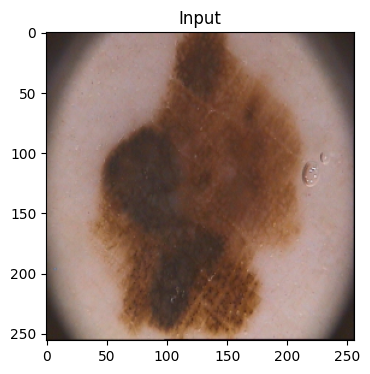

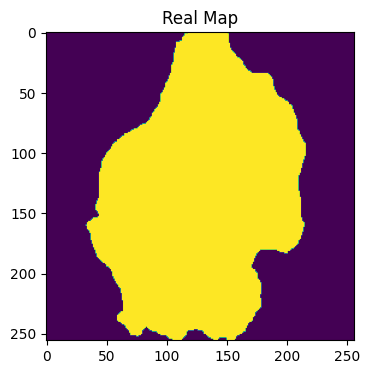

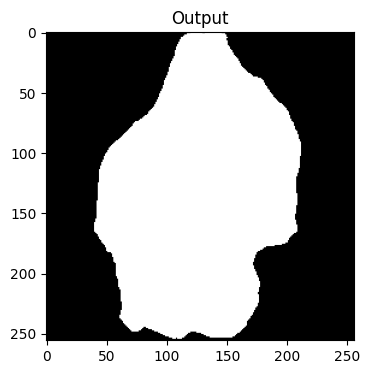

In [59]:
k = 10    # номер картинки
X_val, Y_val = next(iter(data_val))
Y_hat = model_unet2(X_val.cuda()).detach().cpu()

# реальное изображение
plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3))
plt.title('Input')
plt.show()

# реальная маска
plt.imshow(np.rollaxis(Y_val[k].cpu().numpy(), 0, 3))
plt.title('Real Map')
plt.show()

# маска сегметации на выходе сети
plt.imshow((Y_hat[k, 0] > 0).type(torch.long), cmap='gray')
plt.title('Output')
plt.show()

Очевидно, что в основном проблемы сегментации возникают по краям участков.

### **Выводы**
В работе были реализованны две архитектуры для сегментации изображений: SegNet и U-Net. Были имплементированы различные функции потерь. Модель SegNet обучалась 5 раз на следующих функциях потерь: bce, dice, focal, ssim, reg_bce. Модель U-Net обучалась на bce. Декодер модели U-Net реализован двумя способами: upsample и transpose convolution.

В итоге, для модели SegNet, в результате обучения на 50 эпохах, лучший результат показала функция потерь dice с метрикой IoU = 0.68 на тестовой выборке.
Модель U-Net с transpose convolution показала результат при 50 эпохах обучения с метрикой IoU = 0.69.